# Task 3: Data Analysis

## Dataset Loading

We load the dataset from [here](https://eur01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fhuggingface.co%2Fdatasets%2Fallenai%2FWildChat-1M&data=05%7C02%7Cgopika.premsankar%40aalto.fi%7C93206d0f10554ff0997008de1dd0608e%7Cae1a772440414462a6dc538cb199707e%7C1%7C0%7C638980978001437002%7CUnknown%7CTWFpbGZsb3d8eyJFbXB0eU1hcGkiOnRydWUsIlYiOiIwLjAuMDAwMCIsIlAiOiJXaW4zMiIsIkFOIjoiTWFpbCIsIldUIjoyfQ%3D%3D%7C0%7C%7C%7C&sdata=TwhmInXl3hSHO0SB7c7%2Bi2RB9yrXmfQrnZAsjgoNhWg%3D&reserved=0), and import all the necessary libraries.

In [79]:
# load the dataset
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
from collections import defaultdict

ds = load_dataset("allenai/WildChat-1M")
ds

DatasetDict({
    train: Dataset({
        features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header'],
        num_rows: 837989
    })
})

In [60]:
# remove "train" label and keep only its contents
ds = ds['train']
ds

Dataset({
    features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header'],
    num_rows: 837989
})

***

## Encoding Check

Firstly, we will check the encoding used for all available models in the dataset. While this step could be done after we filter the country, it does not matter since all models use the same encoding.

In [61]:
# for every available model in the entire dataset we should check the encoding used
for model in ds.unique('model'):
    print(tiktoken.encoding_for_model(model))

<Encoding 'cl100k_base'>
<Encoding 'cl100k_base'>
<Encoding 'cl100k_base'>
<Encoding 'cl100k_base'>
<Encoding 'cl100k_base'>
<Encoding 'cl100k_base'>
<Encoding 'cl100k_base'>


In [62]:
# we set the encoder to "cl100k_base"
enc = tiktoken.get_encoding("cl100k_base")

***

## Column Removal

In [63]:
# now we remove redundant rows to save space
ds = ds.remove_columns([
    "conversation_hash",
    "language",
    "openai_moderation",
    "detoxify_moderation",
    "toxic",
    "redacted",
    "state",
    "hashed_ip",
    "header",
    "turn",
    "model"
])

In [64]:
ds

Dataset({
    features: ['timestamp', 'conversation', 'country'],
    num_rows: 837989
})

***

## Country Duplicate Check

In [66]:
# we check the countries to make sure no duplicates (e.g US and USA or United States) are existant
list_of_countries = ds.unique("country")
list_of_countries = [x for x in list_of_countries if x is not None]
list_of_countries.sort()
list_of_countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bonaire, Sint Eustatius, and Saba',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo Republic',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'DR Congo',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'French Polynesia',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guadeloupe',
 'Guam',
 'Guatemala',
 'Guernsey',

***

## Filter Dataset Based On Country

It is preferable to work with a smaller dataset so the rest of the preprocessing steps will be applied on each country required.

In [67]:
# all the other preprocessing steps will be applied only on the specific country dataset split
country = "United States" # could be Germany, US, or China

country_ds = ds.filter(lambda x: x['country'] == country).remove_columns(['country'])
country_ds

Filter:   0%|          | 0/837989 [00:00<?, ? examples/s]

Dataset({
    features: ['timestamp', 'conversation'],
    num_rows: 170520
})

In [68]:
# checking a specific entry to the newly created dataset
country_ds[0]

{'timestamp': datetime.datetime(2023, 4, 9, 0, 2, 53, tzinfo=<UTC>),
 'conversation': [{'content': 'Hey there! Are you familiar with reality shifting? So, I’m refining a foolproof method for reality shifting and want to pick a destination. Want to help me? I’m thinking something pretty personalized. There are a few things that are required of my destination. 1. The quest. I have to have a clear overarching goal in my reality, and don’t make it too crazy. It should be more along the lines of “save the president’s daughter” or “escape this weird wacky sinister place” NOT “get an artifact that literally controls reality”. Seriously, don’t make me fetch an artifact, or fetch anything. Instead, make me DO something. 2. Babes. I need pretty girls. 3. The entry. I need to get to lose consciousness in order to begin my journey in my desired reality, preferably by having it knocked out by one of the aforementioned babes. 4. Action. It needs to be cool. 5. Unconsciousness. Myself and the babes n

mention that: If the user turn has no timestamp, we assign the timestamp of the first assistant response.
Since the assistant response is generated immediately after the request, this introduces negligible error in hourly-level aggregation.

***

## Timestamp Assumption and Fix

We notice that for every conversation, the user's part is missing the timestamp feature. However, we assume that the assistant's answer timestamp is always existent and it is generated immediately after the request.

Firstly we will check the assumption that there is always an answer.

In [ ]:
def check_conversation(example):
    convo = example["conversation"]
    valid = True
    
    # check if the last message is from user
    if convo[-1]["role"] == "user":
        valid = False
    else:
        #  check every user message has a following assistant response
        for i, msg in enumerate(convo):
            if msg["role"] == "user":
                # look for next assistant message
                has_response = any(
                    later["role"] == "assistant" for later in convo[i+1:]
                )
                if not has_response:
                    valid = False
                    break
                    
    example["has_full_response"] = valid
    return example

country_ds_checked = country_ds.map(check_conversation)

Map:   0%|          | 0/170520 [00:00<?, ? examples/s]

In [70]:
country_ds_checked.filter(lambda x: x["has_full_response"] == False).num_rows

Filter:   0%|          | 0/170520 [00:00<?, ? examples/s]

0

So the assumption was correct, now we will pass the assistant's answer timestamp to the user's request.

In [71]:
def propagate_timestamps(example):
    convo = example["conversation"]

    for i, msg in enumerate(convo):
        # if there is no timestamp for user, propagate from next assistant
        if msg["role"] == "user" and msg["timestamp"] is None:
            # make sure there is a next message and it is from assistant and timestamp exists
            if i + 1 < len(convo) and convo[i+1]["role"] == "assistant" and convo[i+1]["timestamp"] is not None:
                msg["timestamp"] = convo[i+1]["timestamp"]

        # save back into list
        convo[i] = msg

    example["conversation"] = convo
    return example

country_ds = country_ds.map(propagate_timestamps)

Map:   0%|          | 0/170520 [00:00<?, ? examples/s]

In conclusion, this approach assumes: That every user request does eventually get an assistant response and the assistant response timestamp is the closest possible approximation of when the user message arrived.

***

## Separate Roles

Since each row contains answers and requests, we will split the rows and create a new column (assistant/user) to separate the role.

In [72]:
# we will now generate a new dataset containing each message from a conversation
def row_generator():
    for example in country_ds:
        for msg in example["conversation"]:
            yield {
                "timestamp": msg["timestamp"],
                "content": msg["content"],
                "role": msg["role"],
            }

flattened = Dataset.from_generator(row_generator)

Generating train split: 0 examples [00:00, ? examples/s]

In [73]:
# checking the newly created dataset
flattened

Dataset({
    features: ['timestamp', 'content', 'role'],
    num_rows: 666412
})

In [75]:
# checking the first 4 entries
flattened[:4]

{'timestamp': [datetime.datetime(2023, 4, 9, 0, 2, 53, tzinfo=<UTC>),
  datetime.datetime(2023, 4, 9, 0, 2, 53, tzinfo=<UTC>),
  datetime.datetime(2023, 4, 9, 0, 6, 49, tzinfo=<UTC>),
  datetime.datetime(2023, 4, 9, 0, 6, 49, tzinfo=<UTC>)],
 'content': ['Hey there! Are you familiar with reality shifting? So, I’m refining a foolproof method for reality shifting and want to pick a destination. Want to help me? I’m thinking something pretty personalized. There are a few things that are required of my destination. 1. The quest. I have to have a clear overarching goal in my reality, and don’t make it too crazy. It should be more along the lines of “save the president’s daughter” or “escape this weird wacky sinister place” NOT “get an artifact that literally controls reality”. Seriously, don’t make me fetch an artifact, or fetch anything. Instead, make me DO something. 2. Babes. I need pretty girls. 3. The entry. I need to get to lose consciousness in order to begin my journey in my desired

***

## Tokenize input and output

We now tokenize both input and output and also save the amount of tokens for each request/answer

In [76]:
# given the string in content we produce the tokens, save them in a different column, and also create a column of their amount
def tokenization(example):
    text = example["content"]
    if text is None:
        example["tokens"] = []
        example["amount"] = 0
        return example

    example["tokens"] = enc.encode(text, allowed_special={'<|endoftext|>'})
    example["amount"] = len(example["tokens"])
    return example

flattened = flattened.map(tokenization)

Map:   0%|          | 0/666412 [00:00<?, ? examples/s]

***

## Dictionaries Containing Metrics

Before we assign a day and an hour to each request we first need to make sure all the timezones are the same.

In [77]:
# check that all timezones are the same before sorting
def extract_tz(example):
    return {"tz": str(example["timestamp"].tzinfo)}

tz_dataset = flattened.map(extract_tz)

unique_tz = set(tz_dataset["tz"])
print(unique_tz)

Map:   0%|          | 0/666412 [00:00<?, ? examples/s]

{'UTC'}


Since they are, we can now create 3 different dictionaries to store the amount of requests, input tokens, output tokens, per day and per hour. These are necessary to extract the final metrics.

We basically iterate every row, if the role is 'user' we increment the amount of requests by 1 and increment the amount of tokens for this specific date and hour. If the role is assistant we simply increment the amount of output tokens for this specific day and hour.

In [78]:
# create 3 different dictionaries to store the distributions of requests, input and output tokens.
requests = defaultdict(lambda: defaultdict(int))
input_tokens = defaultdict(lambda: defaultdict(int))
output_tokens = defaultdict(lambda: defaultdict(int))

for row in flattened:
    ts = row["timestamp"]
    date = ts.date().isoformat()
    hour = ts.hour
    if row["role"] == "user":
        requests[date][hour] += 1
        input_tokens[date][hour] += row['amount']
    else:
        output_tokens[date][hour] += row['amount']

We check that the days in all three dictionaries are the same.

In [80]:
sorted(input_tokens.keys()) == sorted(requests.keys()) == sorted(output_tokens.keys())

True

***

## Metrics Calculation

For each one of the 24 hours we create an array containing the distribution of requests/tokens and then we calculate the mean and the std.

In [81]:
hour_stats = {} # will contain metrics for each hour
all_days = sorted(requests.keys()) # same days as input_tokens and output_tokens

for hour in range(24):
    req_counts = [requests[day].get(hour, 0) for day in all_days]
    in_token_counts = [input_tokens[day].get(hour, 0) for day in all_days]
    out_token_counts = [output_tokens[day].get(hour, 0) for day in all_days]
    
    hour_stats[hour] = {
        "requests_mean": np.mean(req_counts),
        "requests_std": np.std(req_counts),
        "input_tokens_mean": np.mean(in_token_counts),
        "input_tokens_std": np.std(in_token_counts),
        "output_tokens_mean": np.mean(out_token_counts),
        "output_tokens_std": np.std(out_token_counts),
    }

***

## Plotting

Firstly we create a plot to check the amount of requests at four distinct hours throughout all days. This allows us to understand how the distributions are expected to come out.

### Requests per day on distinct hours

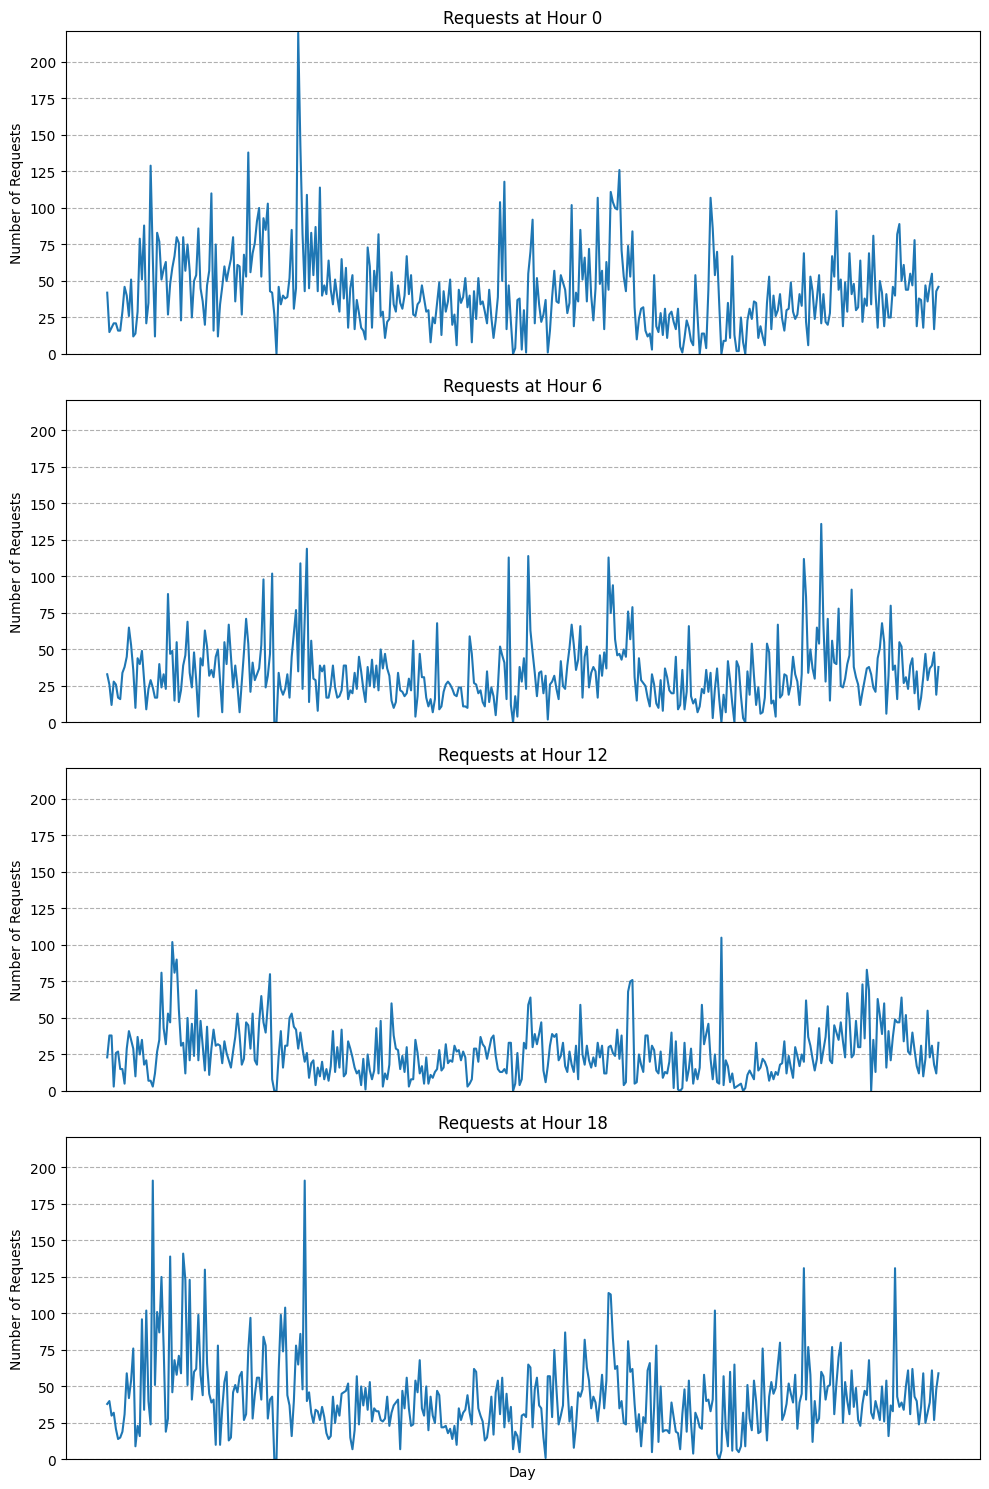

In [82]:
# plot 4 req_counts versus days at hours 0, 6, 12, 18
import matplotlib.pyplot as plt
hours_to_plot = [0, 6, 12, 18]
fig, axs = plt.subplots(len(hours_to_plot), 1, figsize=(10, 15), sharex=True)
for i, hour in enumerate(hours_to_plot):
    requests_counts = [requests[day].get(hour, 0) for day in all_days]
    axs[i].plot(all_days, requests_counts)
    axs[i].set_title(f"Requests at Hour {hour}")
    axs[i].set_ylabel("Number of Requests")
    axs[i].grid(True, axis='y', linestyle='--')
    axs[i].set_xticks([])
    # set y-ticks the same for all plots
    axs[i].set_ylim(0, max(max(requests[day].get(h, 0) for day in all_days) for h in hours_to_plot) + 1)
axs[-1].set_xlabel("Day")
plt.tight_layout()
plt.show()

### Bar plot of requests per hour

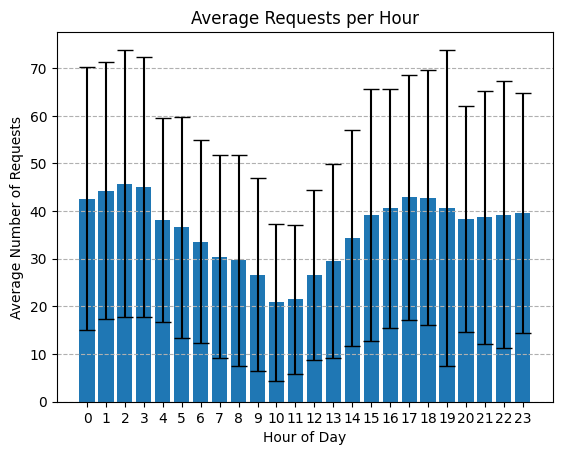

In [83]:
# Plot request distributions as bar charts
import matplotlib.pyplot as plt
hours = list(range(24))
# Since values are positive, the plot should not display values below zero
request_means = [hour_stats[hour]["requests_mean"] for hour in hours]
request_stds = [hour_stats[hour]["requests_std"] for hour in hours]
plt.bar(hours, request_means, yerr=request_stds,linewidth = 2, capsize=6)
plt.xlabel("Hour of Day")
plt.ylabel("Average Number of Requests")
plt.title("Average Requests per Hour")
plt.xticks(hours)
plt.grid(True, axis='y', linestyle='--')
plt.ylim(bottom=0) # Set y-axis
plt.show()

### Box plot of requests per hour

We also construct a sample boxplot to better understand the above plot

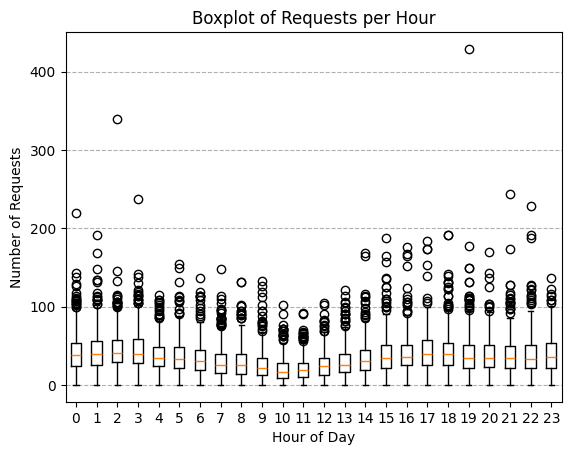

In [84]:
# create boxplot of requests per hour
import matplotlib.pyplot as plt
data = []
for hour in range(24):
    req_counts = [requests[day].get(hour, 0) for day in all_days]
    data.append(req_counts)
plt.boxplot(data, positions=range(24))
plt.xlabel("Hour of Day")
plt.ylabel("Number of Requests")
plt.title("Boxplot of Requests per Hour")
plt.grid(True, axis='y', linestyle='--')
plt.show()

***

### Bar plot of input tokens per hour

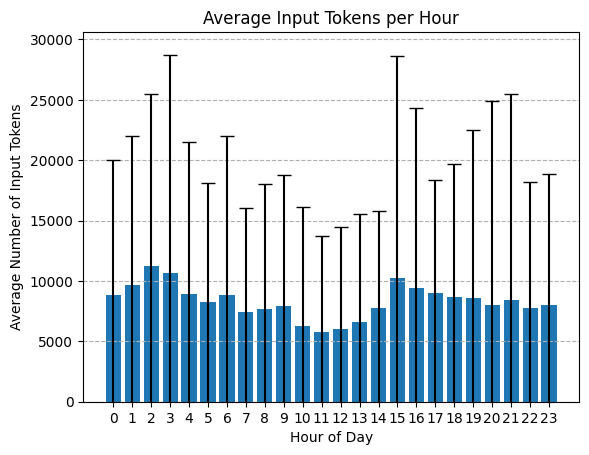

In [85]:
# Plot input tokens distributions as bar charts
hours = list(range(24))
# Since values are positive, the plot should not display values below zero
input_tokens_mean = [hour_stats[hour]["input_tokens_mean"] for hour in hours]
input_tokens_std = [hour_stats[hour]["input_tokens_std"] for hour in hours]
plt.bar(hours, input_tokens_mean, yerr=input_tokens_std, capsize=5)
plt.xlabel("Hour of Day")
plt.ylabel("Average Number of Input Tokens")
plt.title("Average Input Tokens per Hour")
plt.xticks(hours)
plt.grid(True, axis='y', linestyle='--')
plt.ylim(bottom=0) # Set y-axis
plt.show()

### Boxplot of input tokens per hour

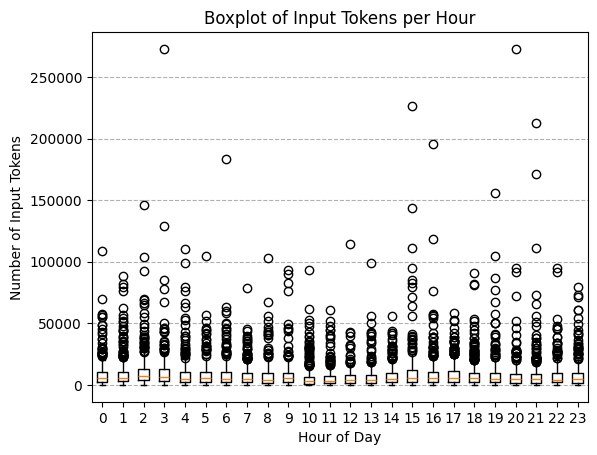

In [88]:
# create boxplot of input tokens per hour
import matplotlib.pyplot as plt
data = []
for hour in range(24):
    input_counts = [input_tokens[day].get(hour, 0) for day in all_days]
    data.append(input_counts)
plt.boxplot(data, positions=range(24))
plt.xlabel("Hour of Day")
plt.ylabel("Number of Input Tokens")
plt.title("Boxplot of Input Tokens per Hour")
plt.grid(True, axis='y', linestyle='--')
plt.show()

***

### Bar plot of output tokens per hour

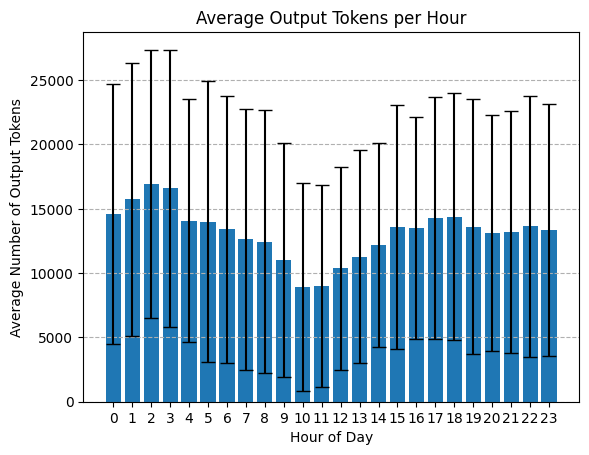

In [86]:
# Plot output tokens distributions as bar charts
hours = list(range(24))
# Since values are positive, the plot should not display values below zero
output_tokens_mean = [hour_stats[hour]["output_tokens_mean"] for hour in hours]
output_tokens_std = [hour_stats[hour]["output_tokens_std"] for hour in hours]
plt.bar(hours, output_tokens_mean, yerr=output_tokens_std, capsize=5)
plt.xlabel("Hour of Day")
plt.ylabel("Average Number of Output Tokens")
plt.title("Average Output Tokens per Hour")
plt.xticks(hours)
plt.grid(True, axis='y', linestyle='--')
plt.ylim(bottom=0) # Set y-axis
plt.show()

### Box plot of output tokens per hour

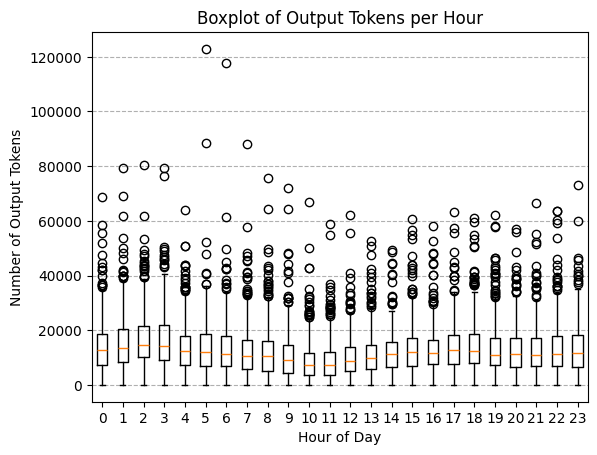

In [89]:
# create boxplot of output tokens per hour
import matplotlib.pyplot as plt
data = []
for hour in range(24):
    output_counts = [output_tokens[day].get(hour, 0) for day in all_days]
    data.append(output_counts)
plt.boxplot(data, positions=range(24))
plt.xlabel("Hour of Day")
plt.ylabel("Number of Output Tokens")
plt.title("Boxplot of Output Tokens per Hour")
plt.grid(True, axis='y', linestyle='--')
plt.show()

***